In [60]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [61]:
import pathlib
data_dir = pathlib.Path('data')
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)


280


# LOAD DATASET

In [62]:
batch_size = 32
# Las imagenes presentes en el dataset se encuentran en una resolucion de 64x64
img_height = 64
img_width = 64

Importamos el dataset con la utilidad de [image dataset from directory para hacerlo de manera mas eficiente](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory).

El usar esta utilidad nos permite ademas de importar las imagenes de manera mas sencilla, el definir los subsets de entrenamiento y validacion.

In [63]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 280 files belonging to 6 classes.
Using 224 files for training.


In [64]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 280 files belonging to 6 classes.
Using 56 files for validation.


Comprobamos que haya usado el nombre de los directorios como etiquetas

In [65]:
class_names = train_ds.class_names
print(class_names)

['Alegria', 'Asco', 'Enojo', 'Miedo', 'Sorpresa', 'Tristeza']


Visualizamos las primeras 9 imagenes presentes en el dataset de entrenamiento

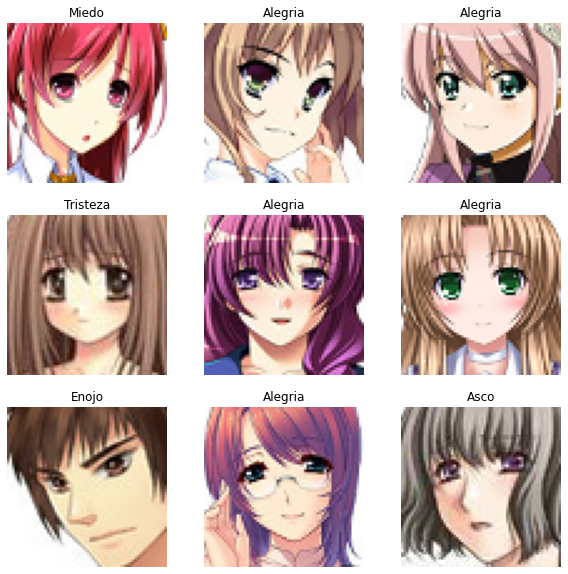

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [67]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 64, 64, 3)
(32,)


In [68]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# ETL

Dentro del modelo estandarizamos las imagenes mediante rescaling, reduciendo el rango de valores de las imagenes, pasando de un rango de 0 a 255 (RGB) a un rango de 0 a 1.

Generamos data augmentation con el fin de tener mas datos para entranar al modelo.

In [69]:
data_augmentation = keras.Sequential(
    [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.4),
    layers.RandomZoom(0.3),
    ]
)

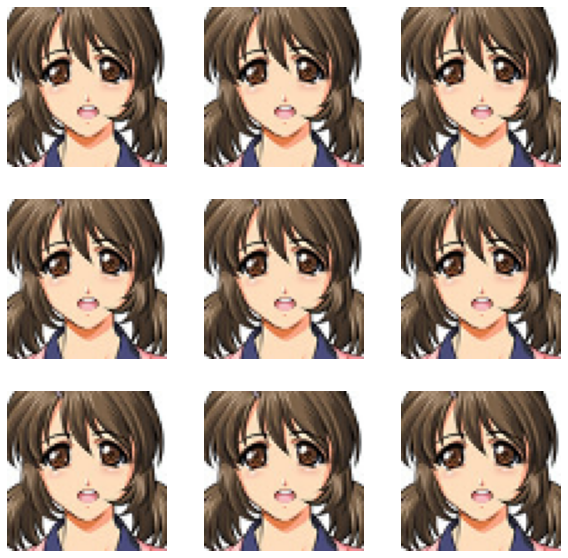

In [70]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# Modelado

In [71]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [72]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Entrenamiento

In [97]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
)

Epoch 1/15
7/7 [==============================] - 0s 38ms/step - loss: 1.2297 - accuracy: 0.5670 - val_loss: 1.2302 - val_accuracy: 0.6786
Epoch 2/15
7/7 [==============================] - 0s 33ms/step - loss: 1.2584 - accuracy: 0.5670 - val_loss: 1.3517 - val_accuracy: 0.6250
Epoch 3/15
7/7 [==============================] - 0s 33ms/step - loss: 1.2268 - accuracy: 0.5714 - val_loss: 1.2931 - val_accuracy: 0.6607
Epoch 4/15
7/7 [==============================] - 0s 34ms/step - loss: 1.2067 - accuracy: 0.5714 - val_loss: 1.3312 - val_accuracy: 0.6071
Epoch 5/15
7/7 [==============================] - 0s 32ms/step - loss: 1.2084 - accuracy: 0.5714 - val_loss: 1.3219 - val_accuracy: 0.6071
Epoch 6/15
7/7 [==============================] - 0s 34ms/step - loss: 1.1863 - accuracy: 0.5670 - val_loss: 1.3109 - val_accuracy: 0.6429
Epoch 7/15
7/7 [==============================] - 0s 33ms/step - loss: 1.1863 - accuracy: 0.6027 - val_loss: 1.2833 - val_accuracy: 0.6786
Epoch 8/15
7/7 [===========

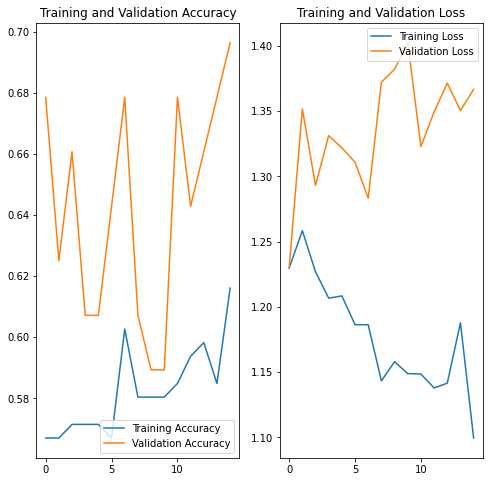

In [98]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [75]:
# model.save_weights('./checkpoints/my_checkpoint')

# Modelo pre entrenado

## MobileNetV2

In [76]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Importamos el modelo pre entrenado

In [77]:
IMG_SHAPE = (64,64) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [78]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 2, 2, 1280)


In [79]:
base_model.trainable = False

In [80]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 32, 32, 32)   864         ['input_13[0][0]']               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 32, 32, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 32, 32, 32)   0           ['bn_Conv1[0][0]']               
                                                                               

Generamos las capas necesarias para realizar nuestras predicciones

In [81]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [82]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Creamos un nuevo modelo a partir de juntar las nuevas capas con el modelo pre entrenado.

In [83]:
# Recibe nuestras imagenes de 64 x 64
inputs = tf.keras.Input(shape=(64, 64, 3))
# Genera datos extras aplicandole transformaciones a los existentes
x = data_augmentation(inputs)

# Reduce el rango de los valores de las imagenes, sustituyendo la capa que haciamos con Rescaling
x = preprocess_input(x)

# Modelo pre entrenado, desativado para no entrenar
x = base_model(x, training=False)

# Capas para generar las predicciones
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)

# Modelo nuevo
model = tf.keras.Model(inputs, outputs)

Compilamos y entrenamos nuestro nuevo modelo

In [84]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [85]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
)

Epoch 1/30
7/7 [==============================] - 4s 105ms/step - loss: 1.6898 - accuracy: 0.4643 - val_loss: 1.2469 - val_accuracy: 0.4107
Epoch 2/30
7/7 [==============================] - 0s 30ms/step - loss: 1.2451 - accuracy: 0.4152 - val_loss: 1.1365 - val_accuracy: 0.3571
Epoch 3/30
7/7 [==============================] - 0s 31ms/step - loss: 0.9387 - accuracy: 0.3839 - val_loss: 1.0472 - val_accuracy: 0.3214
Epoch 4/30
7/7 [==============================] - 0s 31ms/step - loss: 0.4687 - accuracy: 0.3795 - val_loss: 0.9812 - val_accuracy: 0.2500
Epoch 5/30
7/7 [==============================] - 0s 30ms/step - loss: 0.6030 - accuracy: 0.3661 - val_loss: 0.9280 - val_accuracy: 0.1964
Epoch 6/30
7/7 [==============================] - 0s 31ms/step - loss: 0.4531 - accuracy: 0.3036 - val_loss: 0.8891 - val_accuracy: 0.1429
Epoch 7/30
7/7 [==============================] - 0s 31ms/step - loss: 0.3549 - accuracy: 0.2589 - val_loss: 0.8627 - val_accuracy: 0.1250
Epoch 8/30
7/7 [==========

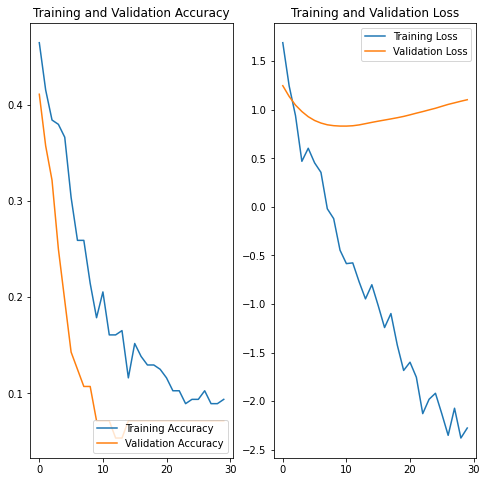

In [86]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Mejoras al modelo

In [197]:
data_augmentation = keras.Sequential(
    [
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.4),
    layers.RandomZoom(0.3),
    ]
)

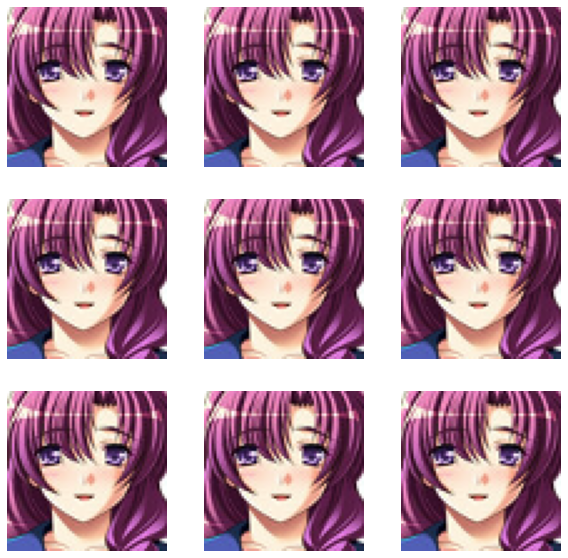

In [198]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [199]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(num_classes, name="outputs")
])

In [200]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [201]:
epochs = 8
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
)

Epoch 1/8
7/7 [==============================] - 3s 46ms/step - loss: 1.4723 - accuracy: 0.5312 - val_loss: 1.1267 - val_accuracy: 0.6786
Epoch 2/8
7/7 [==============================] - 0s 31ms/step - loss: 1.4336 - accuracy: 0.5402 - val_loss: 1.1655 - val_accuracy: 0.6786
Epoch 3/8
7/7 [==============================] - 0s 34ms/step - loss: 1.4058 - accuracy: 0.5402 - val_loss: 1.1598 - val_accuracy: 0.6786
Epoch 4/8
7/7 [==============================] - 0s 32ms/step - loss: 1.4046 - accuracy: 0.5402 - val_loss: 1.1307 - val_accuracy: 0.6786
Epoch 5/8
7/7 [==============================] - 0s 33ms/step - loss: 1.3976 - accuracy: 0.5402 - val_loss: 1.1445 - val_accuracy: 0.6786
Epoch 6/8
7/7 [==============================] - 0s 36ms/step - loss: 1.3787 - accuracy: 0.5402 - val_loss: 1.2002 - val_accuracy: 0.6964
Epoch 7/8
7/7 [==============================] - 0s 36ms/step - loss: 1.3882 - accuracy: 0.5402 - val_loss: 1.2380 - val_accuracy: 0.6786
Epoch 8/8
7/7 [===================

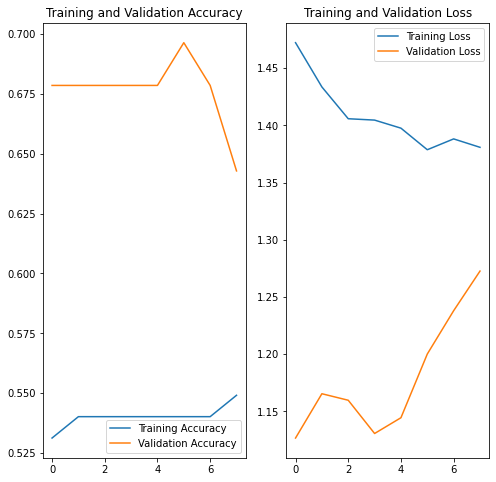

In [202]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Predicciones

Predicciones realizadas con el mejor modelo obtenido.

In [203]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])
model.load_weights('././checkpoints/my_checkpoint')

In [204]:
def predict(model, path):

    img = tf.keras.utils.load_img(
        path, target_size=(64, 64)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    plt.imshow(img_array[0].numpy().astype("uint8"))

    print(
        "El estado de animo es {} con un {:.2f} porciento de confianza."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

1/1 [==============================] - 0s 12ms/step
El estado de animo es Alegria con un 64.95 porciento de confianza.


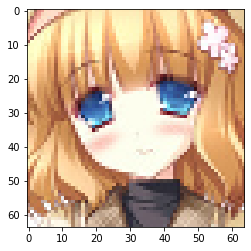

In [209]:
predict(model, '/home/alt9193/Documents/IA/Modulo_DeepLearning/test/Alegria/111.png')

1/1 [==============================] - 0s 13ms/step
El estado de animo es Alegria con un 54.40 porciento de confianza.


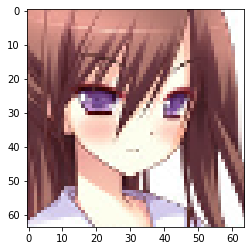

In [210]:
predict(model, '/home/alt9193/Documents/IA/Modulo_DeepLearning/test/Enojo/122.png')

1/1 [==============================] - 0s 15ms/step
El estado de animo es Alegria con un 47.10 porciento de confianza.


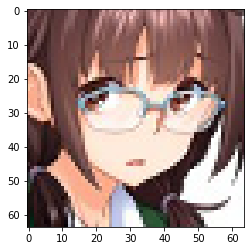

In [211]:
predict(model, '/home/alt9193/Documents/IA/Modulo_DeepLearning/test/Miedo/21403.png')

1/1 [==============================] - 0s 13ms/step
El estado de animo es Alegria con un 38.83 porciento de confianza.


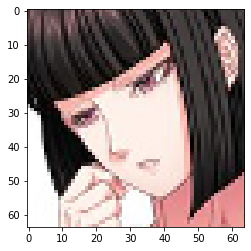

In [208]:
predict(model, '/home/alt9193/Documents/IA/Modulo_DeepLearning/test/Tristeza/21391.png')

# Conclusiones

- Ajustar los hiperparamtros no resultaron en ninguna mejora, pareciendo que los modelos tienen como limite una precision del alrededor del 70%, posiblemente se deba al hecho de que los la clasificacion fue hecha de maneral manual esta presente un sesgo, que hace que imagenes que segun el modelo deberian estar en una categoria se encuentre en una diferente, aunque tambien podria deberse al hecho que el dataset esta desequilibrado entre la categorias.

- Usar data augmentation no parece tener efecto en el datase, o por lo menos no visible.

- Usar un modelo pre entrenado no aporto nada, posiblemente porque fue entrenado para clasificar cuestiones muy diferentes a las presentes en el dataset, haciendo de tal manera que las capaz intermedias del nuevo modelo dadas por el modelo pre enetranado tengan un peor desempeño que realizando la prediccion de forma aleatoria.